In [2]:
"""
visualize results for test image
"""

import os
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
from collections import Counter

import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision

from skimage import io
from skimage.transform import resize

from models import *
import transforms as transforms

In [3]:
cut_size = 44

transform_test = transforms.Compose([
    transforms.TenCrop(cut_size),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
])

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def fit_pred(path='images/1.jpg', save_model=False):
    raw_img = io.imread(path)
    gray = rgb2gray(raw_img)
    gray = resize(gray, (48,48), mode='symmetric').astype(np.uint8)

    img = gray[:, :, np.newaxis]

    img = np.concatenate((img, img, img), axis=2)
    img = Image.fromarray(img)
    inputs = transform_test(img)

    class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

    net = VGG('VGG19')
    checkpoint = torch.load(os.path.join('../models/', 'classifier.t7'), map_location='cpu')
    net.load_state_dict(checkpoint['net'])
    net.eval()

    ncrops, c, h, w = np.shape(inputs)

    if save_model:
        traced_script_module = torch.jit.trace(net, inputs)
        traced_script_module.save("../models/emotion_recognition.pt")
    
    inputs = inputs.view(-1, c, h, w)
    
    inputs = Variable(inputs, volatile=True)
    outputs = net(inputs)

    outputs_avg = outputs.view(ncrops, -1).mean(0)  # avg over crops

    score = F.softmax(outputs_avg)
    _, predicted = torch.max(outputs_avg.data, 0)

    predicted_emotion = class_names[int(predicted.cpu().numpy())]
    return predicted_emotion

In [4]:
from tqdm import tqdm
from IPython.display import clear_output

In [30]:
PATH = '../datasets/crop/'
POS = PATH + 'train_A'
NEG = PATH + 'train_B'

In [32]:
fit_pred(path='{}/{}'.format(path, im), save_model=True)

/anaconda3/envs/py36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


'Happy'

In [19]:
# def check_emotion(path):
res = {}
path = POS
for im in tqdm(os.listdir(path)):
    res[im] = fit_pred(path='{}/{}'.format(path, im))
    clear_output()

Counter(res.values())

100%|██████████| 50/50 [00:24<00:00,  2.06it/s]


In [21]:
# def check_emotion(path):
res = {}
path = NEG
false_pos = []
for im in tqdm(os.listdir(path)):
    ans = fit_pred(path='{}/{}'.format(path, im))
    res[im] = ans
    if ans == 'Happy':
        false_pos.append(im)
    clear_output()
    
Counter(res.values())

100%|██████████| 48/48 [00:23<00:00,  2.05it/s]


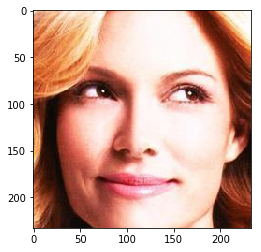

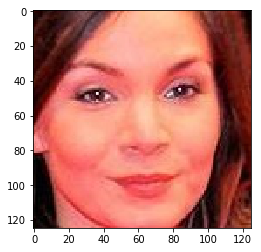

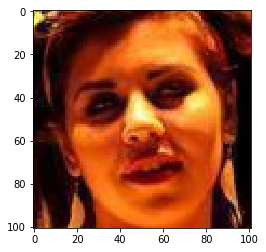

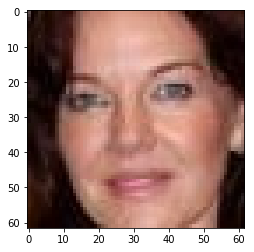

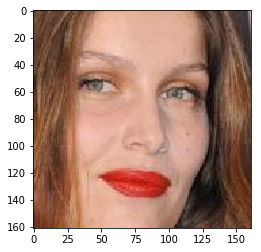

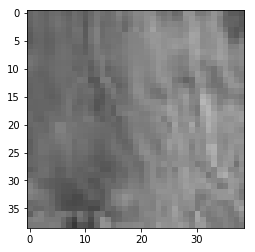

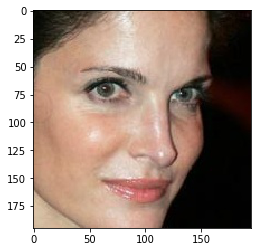

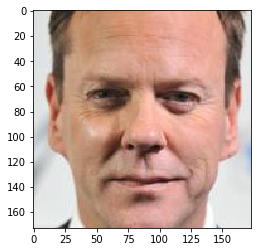

In [24]:
for im in false_pos:
    img = plt.imread('{}/{}'.format(path, im))
    plt.imshow(img)
    plt.show()